# Age discrepancy

Now we will try to correlate age discrepancy with some scores of the behavioral dataset. Our model to predict age uses only the structural MRI features.

In [6]:
import warnings
warnings.filterwarnings('ignore')
from utils import create_dataset_mri, cv_for_cde, create_dataset_eeg
from cde.density_estimator import MixtureDensityNetwork
import numpy as np
import tensorflow as tf
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tensorflow.python.keras.activations import tanh
from sklearn.impute import SimpleImputer
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

In [7]:
# Fix a age threshold
threshold = 16

In [8]:
# Behavioral data
behavioral = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv')
# Create dataset MRI
target = 'Age'
data = create_dataset_mri(SCORE = target)
data.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)
data = data[data['Age']<threshold]

In [9]:
# labels and features
y = data[target]
X = data.drop([target], axis=1)
X = np.array(X)
y = np.array(y)

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=988)
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
ID_train = X_train[:,0]
X_train = X_train[:,1:]
ID_test = X_test[:,0]
X_test = X_test[:,1:]
y_train = np.array(y_train, dtype=np.float64)
X_train = np.array(X_train, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64)

In [10]:
# Set model parameters
ndim_x=X_train.shape[1]
ndim_y=y_train.shape[1]
# We try the "faster decay rate for non-gaussian data" proposed in the paper: h = n^(-1/(d+1))
n = X_train.shape[0]
d = X_train.shape[1]+y_train.shape[1]
h = n**(-1/(d+1))
# Define the model
model = MixtureDensityNetwork('MDN', ndim_x, ndim_y, n_centers=10, hidden_sizes=(16, 16), hidden_nonlinearity=tf.nn.tanh,
               n_training_epochs=1000, x_noise_std=h, y_noise_std=h, adaptive_noise_fn=None, entropy_reg_coef=0.0,
               weight_decay=0.0, weight_normalization=True, data_normalization=True, dropout=0.0, l2_reg=0.0, l1_reg=0.0,
               random_seed=42)
# Fit
model.fit(X_train, y_train)
# Predict
y_pred = model.mean_(X_test)
y_pred = y_pred.reshape((-1,1))
y_pred.shape
print('Test MSE: {}'.format(mean_squared_error(y_pred, y_test)))

1000/1000 [100%] ██████████████████████████████ Elapsed: 16s | loss: 742.733
mean log-loss train: 1.4650
Test MSE: 4.561712718918008


In [11]:
# Define discrepancy
std = model.std_(X_test)
discrepancy = np.divide((y_test-y_pred), 1+std)
#discrepancy = y_test-y_pred

In [12]:
# Get dataframe for test observations with behavioral data + discrepancy
data = {'discrepancy':discrepancy[:,0]}
discrepancy_df = pd.DataFrame(data)
ID_df = pd.DataFrame({'EID':ID_test})
discrepancy_merged = pd.concat([ID_df, discrepancy_df], axis=1)
dataframe = pd.merge(discrepancy_merged, behavioral, how='inner', on='EID')
dataframe = dataframe.drop(['Anonymized.ID', 'Study.Site'], axis = 1)

In [13]:
# Get the correlations
correlations = dataframe[dataframe.columns[1:]].corr()['discrepancy'][:]
# Inspect correlations
correlations[correlations > 0.3]  

discrepancy              1.000000
Age                      0.545997
DX_05_RuleOut            0.376305
DX_06_Rem                0.328344
DX_07_New                0.649441
DX_08_New                1.000000
CBCL_Pre_AB              0.345849
CBCL_Pre_WD              0.333958
CBCL_Pre_Ext             0.352364
CELF_WC_R                0.442063
CELF_FS_R                0.535738
CLEF5M_CS_Raw            0.302524
CLEF5M_MM_Raw            0.305392
EVT2_RawScore            0.362463
FGC_Curl_Up              0.302427
KBIT_NV_Raw              0.529277
KBIT_V_Raw               0.443335
List_Sort_Raw            0.330068
Picture_Seq_Raw          0.348855
PPVT4_RawScore           0.450587
TOWRE_SWE_Raw            0.312163
TRF_Pre_Somatic_Raw      0.325552
TRF_Pre_Total_Raw        0.393625
VL_Comm1_Raw             0.993475
VL_Comm2_Raw             0.812415
VL_DLS1_Raw              0.997127
VL_DLS2_Raw              0.999831
VL_DLS3_Raw              0.973208
VL_Social1_Raw           0.561902
VL_Social2_Raw

In [14]:
# Frequencies of major disturb in behavioral dataset
dataframe['DX_01'].value_counts().head(10)

ADHD-Combined Type                                          107
ADHD-Inattentive Type                                        92
No Diagnosis Given                                           73
Specific Learning Disorder with Impairment in Reading        32
No Diagnosis Given: Incomplete Eval                          29
Autism Spectrum Disorder                                     26
Generalized Anxiety Disorder                                 17
Other Specified Attention-Deficit/Hyperactivity Disorder     13
Social Anxiety (Social Phobia)                               12
Major Depressive Disorder                                    11
Name: DX_01, dtype: int64

In [15]:
df = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type', 'ADHD-Inattentive Type','No Diagnosis Given', 'Autism Spectrum Disorder', 'Specific Learning Disorder with Impairment in Reading'])]

Text(0.5, 1.0, 'Age discrepancy vs age')

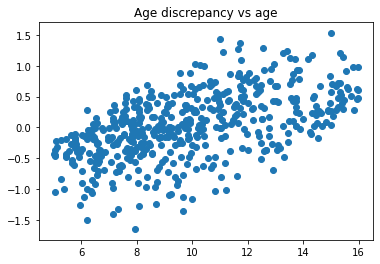

In [16]:
dat = dataframe[dataframe['Age']<threshold]
plt.scatter(np.array(dat['Age']), np.array(dat['discrepancy']))
plt.title('Age discrepancy vs age')

## Consider the most frequent situations: ADHD Inattentive, ADHD Combined, Autism, Healthy. Specific impairment in Reading

In [17]:
df = df[df['Age']<threshold]

## t-test Healthy vs ADHD Inattentive

In [18]:
adhd = df[df['DX_01'] == 'ADHD-Inattentive Type']['discrepancy']
no_adhd = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
from scipy.stats import ttest_ind
res = ttest_ind(np.array(adhd), np.array(no_adhd), equal_var=False)
res

Ttest_indResult(statistic=3.726637614816906, pvalue=0.0002673817099861127)

Text(0.5, 1.0, 'Healthy and ADHD-Inattentive')

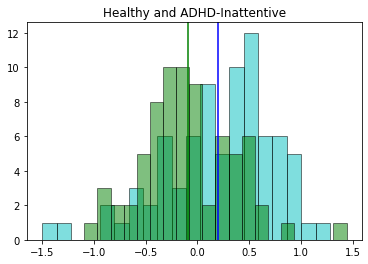

In [19]:
import matplotlib.pyplot as plt
plt.hist(adhd[:80], bins=20, color='c', edgecolor='k', alpha=0.5)     # take same number of obs as no_adhd
plt.hist(no_adhd, bins=20, color='g', edgecolor='k', alpha=0.5)
plt.axvline(x=np.mean(adhd), color = 'b')
plt.axvline(x=np.mean(no_adhd), color = 'g')
plt.title('Healthy and ADHD-Inattentive')

## t-test Healthy vs Autism

In [20]:
autism = df[df['DX_01'] == 'Autism Spectrum Disorder']['discrepancy']
healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
from scipy.stats import ttest_ind
res = ttest_ind(np.array(autism), np.array(healthy), equal_var=False)
res

Ttest_indResult(statistic=2.7545400357058103, pvalue=0.00905454587904961)

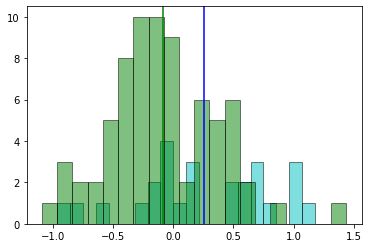

In [21]:
import matplotlib.pyplot as plt
plt.hist(autism, bins=20, color='c', edgecolor='k', alpha=0.5)     # take same number of obs as no_adhd
plt.hist(healthy, bins=20, color='g', edgecolor='k', alpha=0.5)
plt.axvline(x=np.mean(autism), color = 'b')
plt.axvline(x=np.mean(healthy), color = 'g')

# Visualization

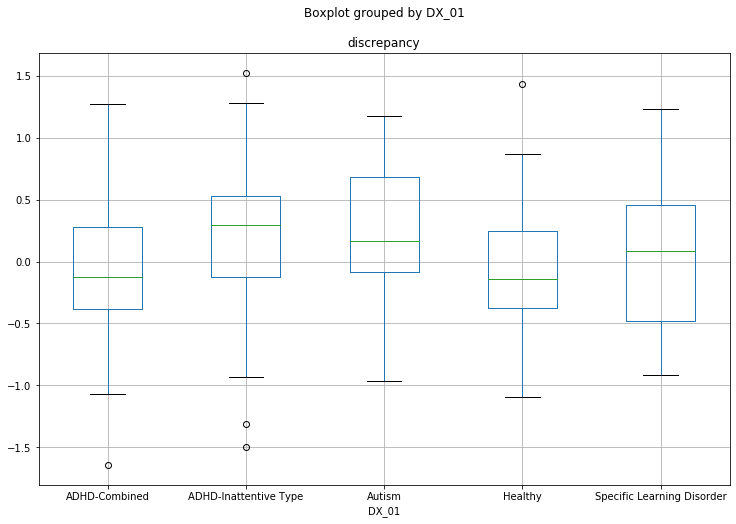

In [22]:
#Create a boxplot
df = df.replace({'ADHD-Combined Type':'ADHD-Combined', 'ADHD_Inattentive Type':'ADHD-Inattentive', 'Autism Spectrum Disorder':'Autism', 'No Diagnosis Given':'Healthy', 'Specific Learning Disorder with Impairment in Reading':'Specific Learning Disorder'})
df.boxplot('discrepancy', by='DX_01', figsize=(12, 8))

## Evaluate these quantities as an average over differen splits

In [4]:
def t_test(repetitions, multiple_testing_correction = 'fdr_bh', exclude_old = True, threshold = threshold):
    # Behavioral data
    behavioral = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv')
    # Create dataset MRI
    target = 'Age'
    data = create_dataset_mri(SCORE = target)
    data.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)
    if exclude_old == True:
        data = data[data['Age']<threshold]
    # labels and features
    y = data[target]
    X = data.drop([target], axis=1)
    X = np.array(X)
    y = np.array(y)
    # things I want to compute
    t_adhd = []
    t_adhd_combined = []
    t_autism = []
    t_impaired = []

    
    for i in range(repetitions):
        # split the dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=i)   #rs=2
        y_train = y_train.reshape((-1,1))
        y_test = y_test.reshape((-1,1))
        ID_train = X_train[:,0]
        X_train = X_train[:,1:]
        ID_test = X_test[:,0]
        X_test = X_test[:,1:]
        y_train = np.array(y_train, dtype=np.float64)
        X_train = np.array(X_train, dtype=np.float64)
        y_test = np.array(y_test, dtype=np.float64)
        X_test = np.array(X_test, dtype=np.float64)
        # Set model parameters
        ndim_x=X_train.shape[1]
        ndim_y=y_train.shape[1]
        # We try the "faster decay rate for non-gaussian data" proposed in the paper: h = n^(-1/(d+1))
        n = X_train.shape[0]
        d = X_train.shape[1]+y_train.shape[1]
        h = n**(-1/(d+1))
        model = MixtureDensityNetwork('{}'.format(i), ndim_x, ndim_y, n_centers=10, hidden_sizes=(16, 16), hidden_nonlinearity=tf.nn.tanh,
               n_training_epochs=1000, x_noise_std=h, y_noise_std=h, adaptive_noise_fn=None, entropy_reg_coef=0.0,
               weight_decay=0.0, weight_normalization=True, data_normalization=True, dropout=0.0, l2_reg=0.0, l1_reg=0.0,
               random_seed=42)
        # Fit
        model.fit(X_train, y_train)
        # Predict
        y_pred = model.mean_(X_test)
        y_pred = y_pred.reshape((-1,1))
        # Define discrepancy
        std = model.std_(X_test)
        discrepancy = np.divide((y_test-y_pred), 1+std)
        # Get dataframe for test observations with behavioral data + discrepancy
        data = {'discrepancy':discrepancy[:,0]}
        discrepancy_df = pd.DataFrame(data)
        ID_df = pd.DataFrame({'EID':ID_test})
        discrepancy_merged = pd.concat([ID_df, discrepancy_df], axis=1)
        dataframe = pd.merge(discrepancy_merged, behavioral, how='inner', on='EID')
        
        # Select most frequent diseases
        df = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type', 'ADHD-Inattentive Type','No Diagnosis Given', 'Autism Spectrum Disorder', 'Specific Learning Disorder with Impairment in Reading'])]
        
        # t-test for autism vs healthy
        autism = df[df['DX_01'] == 'Autism Spectrum Disorder']['discrepancy']
        healthy = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res1 = ttest_ind(np.array(autism), np.array(healthy), equal_var=False)
        
        
        # t-test for inattentive vs healthy
        adhd = df[df['DX_01'] == 'ADHD-Inattentive Type']['discrepancy']
        no_adhd = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res2 = ttest_ind(np.array(adhd), np.array(no_adhd), equal_var=False)
        
        
        # t-test for combined vs healthy
        combined = df[df['DX_01'] == 'ADHD-Combined Type']['discrepancy']
        no_combined = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res3 = ttest_ind(np.array(combined), np.array(no_combined), equal_var=False)
        
        # t-test for impaired vs healthy
        combined = df[df['DX_01'] == 'Specific Learning Disorder with Impairment in Reading']['discrepancy']
        no_combined = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res4 = ttest_ind(np.array(combined), np.array(no_combined), equal_var=False)
        
        # Correct p-values for multiple-testing
        p_vals = [res1[1], res2[1], res3[1], res4[1]]
        corrected = multipletests(pvals = p_vals, alpha=0.05, method = multiple_testing_correction)
        t_autism.append(corrected[1][0])
        t_adhd.append(corrected[1][1])
        t_adhd_combined.append(corrected[1][2])
        t_impaired.append(corrected[1][3])
    
    print('Mean t-test p-val (inattentive vs healthy): {} \n Mean t-test p-val (combined vs healthy): {} \n Mean t-test p-val (autism vs healthy): {} \n Mean t-test p-val (impaired vs healthy): {}'.format(np.mean(t_adhd), np.mean(t_adhd_combined), np.mean(t_autism), np.mean(t_impaired)))

In [5]:
t_test(10)

1000/1000 [100%] ██████████████████████████████ Elapsed: 12s | loss: 719.810
mean log-loss train: 1.4197
1000/1000 [100%] ██████████████████████████████ Elapsed: 11s | loss: 730.945
mean log-loss train: 1.4417
1000/1000 [100%] ██████████████████████████████ Elapsed: 10s | loss: 756.922
mean log-loss train: 1.4929
1000/1000 [100%] ██████████████████████████████ Elapsed: 13s | loss: 746.980
mean log-loss train: 1.4733
1000/1000 [100%] ██████████████████████████████ Elapsed: 13s | loss: 724.781
mean log-loss train: 1.4295
1000/1000 [100%] ██████████████████████████████ Elapsed: 26s | loss: 735.184
mean log-loss train: 1.4501
1000/1000 [100%] ██████████████████████████████ Elapsed: 21s | loss: 740.433
mean log-loss train: 1.4604
1000/1000 [100%] ██████████████████████████████ Elapsed: 20s | loss: 750.690
mean log-loss train: 1.4807
1000/1000 [100%] ██████████████████████████████ Elapsed: 20s | loss: 753.631
mean log-loss train: 1.4865
1000/1000 [100%] ██████████████████████████████ Elapsed

Using the Benjamini-Hochberg correction for p-values.